# Lensing of a color image

This notebook walks you through a simple example of taking an image (in r,g,b colors), lens it, and create a colored lensed image.

In [20]:
# standard python imports
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
# try:
#     import lenstronomy
# except:
#     %pip install lenstronomy


# we use the LensModel and LightModel routines
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel


### Make lens model and perform ray tracing

Here we set up a lens model, define a coordinate grid and ray-trace the image positions back to the source plane.

Lo primero que vamos a hacer es definir los modelos utilizados para la lente y sus argumentos:

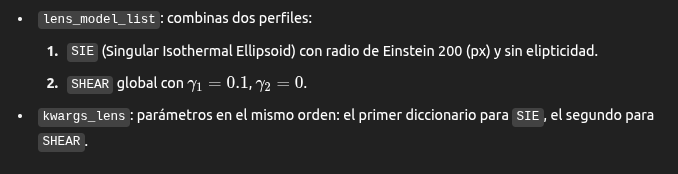

In [21]:
lens_model_list = ["SIE", "SHEAR"]
lens_model = LensModel(lens_model_list=lens_model_list)


kwargs_lens = [{"theta_E": 200, "e1": 0, "e2": 0, "center_x": 0, "center_y": 0},
               {"gamma1": 0.1, "gamma2": 0}]

Luego creamos la rejilla de rayos donde estará la imagen


In [22]:
num_pix = 1000      # resolución de la cuadrícula
deltapix = 1        # escala = 1 (trabajamos en unidades de píxel)

import lenstronomy.Util.util as util
x, y = util.make_grid(numPix=num_pix, deltapix=deltapix)
x2d = util.array2image(x)
y2d = util.array2image(y)


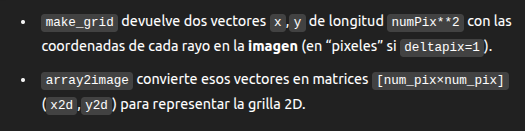

y ahora se trazan los rayos

In [23]:
beta_x, beta_y = lens_model.ray_shooting(x2d, y2d, kwargs_lens)

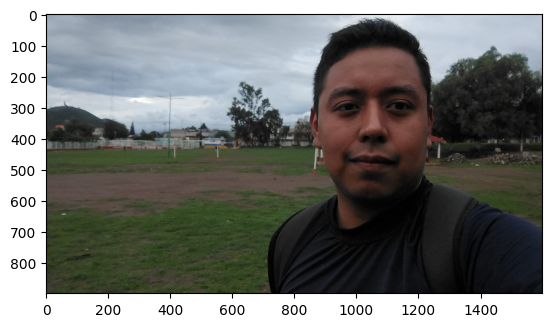

In [24]:
from PIL import Image
_path = os.getcwd()
# Subimos dos niveles para llegar a la carpeta raíz del proyecto
base_path = os.path.split(os.path.split(_path)[0])[0]
path_data = os.path.join(base_path, "data")

img = Image.open("/home/kingsman/Escritorio/Lenstronomy/lenstronomy-tutorials/Data/yop.jpeg")
image_array = np.asarray(img)
plt.imshow(image_array)
plt.show()

In [25]:
#colors
image_r = image_array[:, :, 0].astype(float)
image_g = image_array[:, :, 1].astype(float)
image_b = image_array[:, :, 2].astype(float)


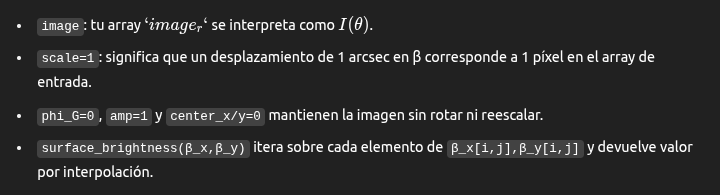

In [26]:
# 1) Elegimos el perfil INTERPOL para cada canal
light_model_list = ["INTERPOL"]

# 2) Rojo (R)
light_model_r = LightModel(light_model_list=light_model_list)
kwargs_light_r = [{
    "image":   image_r,   # 2D array con canal rojo original
    "amp":     1,         # escala lineal (here 1 → toma valor directo)
    "center_x":0,         # ancla x del origen de 'image' en arcsec
    "center_y":0,         # ancla y
    "phi_G":   0,         # rotación del perfil (rad)
    "scale":   1          # factor que relaciona unidades de β con píxeles de 'image'
}]
image_r_lensed = light_model_r.surface_brightness(
    beta_x, beta_y, kwargs_light_r)



In [27]:
#same for green and blue
light_model_g = LightModel(["INTERPOL"])
kwargs_light_g = [{ "image": image_g, "amp":1, "center_x":0, "center_y":0, "phi_G":0, "scale":1 }]
image_g_lensed = light_model_g.surface_brightness(beta_x, beta_y, kwargs_light_g)

light_model_b = LightModel(["INTERPOL"])
kwargs_light_b = [{ "image": image_b, "amp":1, "center_x":0, "center_y":0, "phi_G":0, "scale":1 }]
image_b_lensed = light_model_b.surface_brightness(beta_x, beta_y, kwargs_light_b)


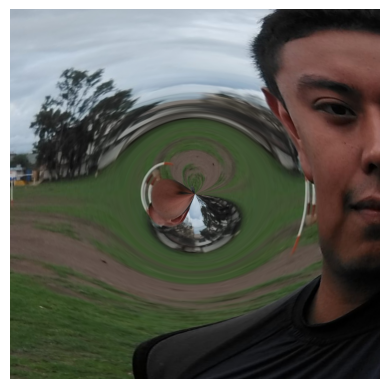

In [28]:
# 3) Reensamblar canales en una imagen RGB final
height, width = image_b_lensed.shape
image_lensed = np.zeros((height, width, 3), dtype=np.uint8)

image_lensed[:, :, 0] = image_r_lensed  # canal rojo
image_lensed[:, :, 1] = image_g_lensed  # canal verde
image_lensed[:, :, 2] = image_b_lensed  # canal azul

# 4) Mostrar
plt.imshow(image_lensed)
plt.axis('off')
plt.show()


In [30]:
image_lensed.shape
#plt.imshow(image_lensed)

(1000, 1000, 3)

### Ahora vamos a hacer el lenteo de un perfil de una galaxia

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import lenstronomy.Util.util as util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

from lenstronomy.Data.pixel_grid import PixelGrid

import lenstronomy.Util.param_util as param_util #ayuda a definir las cosas para los modelos paramétricos de brillo}


Vamos a generar dos grids, uno para el plano fuente (donde irá la galaxia original) y uno para el plano del observador (imagen lenteada)

In [11]:
#pixeles de nuestras imagenes y tamaño de pixel en arcsecs
n_pixeles = 100
delta = 0.05


# x-axis is going W and y-axis is going N
#Con los dos números de arriba, la imagen va a medir 5 arcsecs, entonces el centro va en:
ra_at_xy_0, dec_at_xy_0 = 2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)

#Las componentes de la matriz de conversión son entonces:
CD1_1, CD1_2, CD2_1, CD2_2 = -delta, 0, 0, delta  # transformation matrix elements (in units arc seconds, transform the 'CD1_1' elements etc. of the fits header in arc seconds!)
transform_pix2angle = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])  # linear translation matrix of a shift in pixel in a shift in coordinates

#Argumentos que entran a Pixelgrid
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

#creamos la malla
pixel_grid = PixelGrid(**kwargs_pixel)
#las cooedenadas donde se ubican los píxeles
x_grid, y_grid = pixel_grid.pixel_coordinates

In [12]:
# #fuente
# x, y = util.make_grid(numPix=n_pixeles, deltapix=delta)
# x2d = util.array2image(x)
# y2d = util.array2image(y)

Vamos a dibujar el mapa de brillo

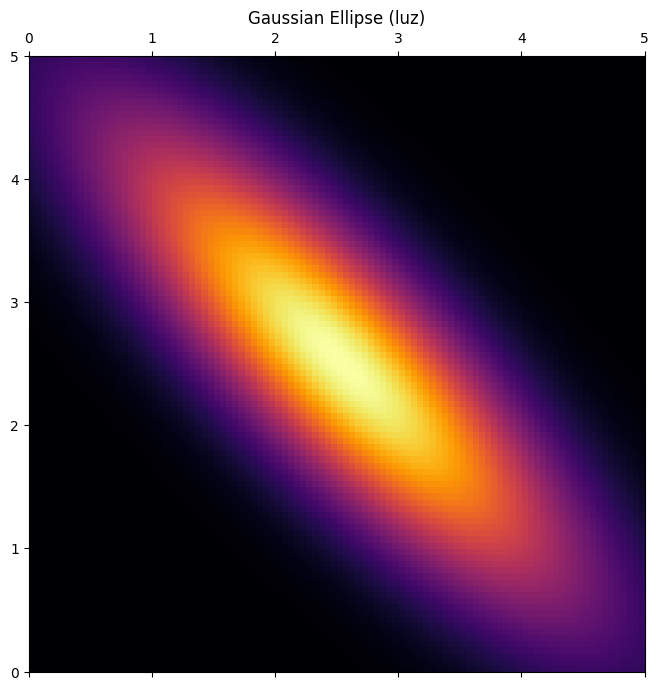

In [13]:
# axis ratio (minor/major axis)
q = 0.3
# angle of major axis (radian)
phi = 0.8 # major axis direction from E to N
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)
# inverse transformation for completeness (redundant)
# phi, q = param_util.ellipticity2phi_q(e1, e2)
# print(q)

#phi_q2_ellipticity calcula exactamente e_1=ecos2ϕ,e_2=esin2ϕ.
#ellipticity2phi_q invierte la transformación.
#Según cuales sean nuestras coordenadas vamos a usar cada una

# # 1) Instanciamos el modelo con un solo perfil
light = LightModel(light_model_list=['GAUSSIAN_ELLIPSE'])

# 2) Parámetros: amp, sigma (ancho), elipticidad y centro
kwargs_light = [{
    'amp':      1.0,      # normalización de la luz
    'sigma':    1.0,      # tamaño del Gaussiano en arcsec
    'e1':       e1,       # componente x de la elipticidad
    'e2':       e2,       # componente y
    'center_x': 0.0,      # posición x (arcsec)
    'center_y': 0.0       # posición y (arcsec)
}]

# 3) Evaluamos la superficie de brillo en cada punto de la rejilla
flux = light.surface_brightness(x_grid, y_grid, kwargs_light)

# 4) Pintamos
fig, ax = plt.subplots(figsize=(8,8))
ax.matshow(flux, origin='lower', cmap='inferno',
           extent=[0, delta*n_pixeles, 0, delta*n_pixeles])
# plot_util.coordinate_arrows(ax, d=n_pixeles,
#                             coords=pixel_grid,
#                             color='w',
#                             font_size=12,
#                             arrow_size=0.02)
ax.set_title('Gaussian Ellipse (luz)')
plt.show()

Ahora toca crear un grid para el plano del observador donde estará la imagen lenteada


In [14]:
lens_model_list = ["SIE", "SHEAR"]
lens_model = LensModel(lens_model_list=lens_model_list)


kwargs_lens = [{"theta_E": 2, "e1": 0, "e2": 0, "center_x": 0, "center_y": 0},
               {"gamma1": 0.1, "gamma2": 0}]

In [15]:
# 1) Defino pixelgrid y obtengo x_grid,y_grid (plano imagen)
#x_grid, y_grid = pixel_grid.pixel_coordinates

# 2) Calculo la correspondencia fuente→imagen inversa
beta_x, beta_y = lens_model.ray_shooting(x_grid, y_grid, kwargs_lens)

# 3) Interpolo mi imagen fuente en (beta_x,beta_y) para obtener la imagen lenteada
#image_lensed = light_model.surface_brightness(beta_x, beta_y, kwargs_light)


In [16]:
# 1) Elegimos el perfil INTERPOL para cada canal
light_model_list = ["INTERPOL"]

# 2) Rojo (R)
light_model = LightModel(light_model_list=light_model_list)
kwargs_light = [{
    "image":   flux,   # 2D array con canal rojo original
    "amp":     1,         # escala lineal (here 1 → toma valor directo)
    "center_x":0,         # ancla x del origen de 'image' en arcsec
    "center_y":0,         # ancla y
    "phi_G":   0,         # rotación del perfil (rad)
    "scale":   1          # factor que relaciona unidades de β con píxeles de 'image'
}]
image_lensed = light_model.surface_brightness(
    beta_x, beta_y, kwargs_light)



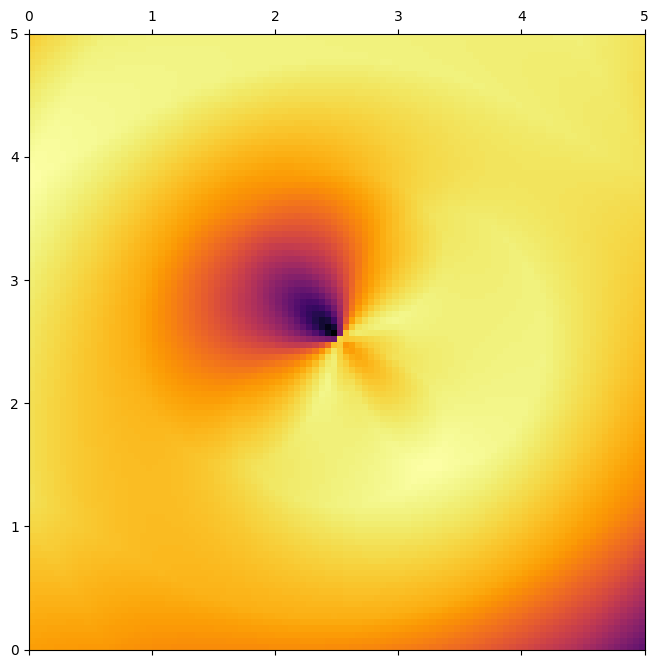

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.matshow(image_lensed, origin='lower', cmap='inferno',
           extent=[0, delta*n_pixeles, 0, delta*n_pixeles])